# Import data and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import xgboost as xgb
import seaborn as sns
import datetime as dt

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
store_info = pd.read_csv('store.csv')
training = pd.read_csv('train.csv')
testing = pd.read_csv('test.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


I notice that there are missing value in Open column.

In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Inspired by [Gert's report](https://www.kaggle.com/c/rossmann-store-sales/discussion/18024). I decide to try a new way to approach.

# Feature Processing of Training&Testing

In [6]:
training.StateHoliday.replace(to_replace='0',value=0,inplace=True)
testing.StateHoliday.replace(to_replace='0',value=0,inplace=True)

In [7]:
testing[(testing.Open!= 0.0)&(testing.Open!= 1.0)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


Base on DayOfWeek and StateHoliday I think missing values should be 1, which means they are suppose to open.

In [8]:
testing.Open.fillna(1,inplace=True)
testing.Open= testing.Open.astype(int)
print(testing.Open.value_counts())

1    35104
0     5984
Name: Open, dtype: int64


## Date data processing( create artifical features

In [9]:
def change_to_datetime(list_):
    """Change str to datetime object"""
    new= []
    for i in list_:
        date = dt.datetime.strptime(i,'%Y-%m-%d')
        new.append(date)
    return new

# acquire all state holiday dates
state_holiday= training.Date[training.StateHoliday!=0].unique().tolist() # from training set
state_holiday_= testing.Date[testing.StateHoliday=='a'].unique().tolist() # from testing set
state_holiday.append(state_holiday_[0])
state_holiday.append('2015-09-19') 
# Add an extra holiday date to calculate days to holiday(how long to the next nearest holiday)
# Reference https://www.officeholidays.com/countries/germany/2015.php an additional holiday date
state_holiday= change_to_datetime(state_holiday)



def days_to_holiday(dataset):
    """Take dataset as input and also call the output from change_to_datetime()
        then calculate the day to/from latest holidays
    """
    
    # Initialize two column with values equal to its Store number
    dataset.day_to_holiday= dataset.Store 
    dataset.day_from_holiday= dataset.Store
    dates_unique= dataset.Date.unique().tolist() # Load all unique dates in dataset

    for current in dates_unique:
        current_date= dt.datetime.strptime(current,'%Y-%m-%d')
        
        smallest_positive= 5000 # set the default value of oncoming holiday 
        biggest_negative= -5000 # set the default value of past holiday
        
        for holiday_date in state_holiday: # Loop for all state holiday and calculate the gap with current date
            gap = (holiday_date- current_date).days
            if gap > 0:
                if gap < smallest_positive:
                    smallest_positive= gap
            elif gap <0:
                if gap > biggest_negative:
                    biggest_negative= gap
            else:
                smallest_positive= gap
                biggest_negative= gap
            
        dataset.loc[dataset.Date== current,'day_to_holiday']= smallest_positive
        dataset.loc[dataset.Date== current,'day_from_holiday']= abs(biggest_negative)
        
    return dataset


testing= days_to_holiday(testing)
training= days_to_holiday(training)

# Modify column type
testing.day_to_holiday = testing.day_to_holiday.astype(int)
testing.day_from_holiday= testing.day_from_holiday.astype(int)

training.day_to_holiday = training.day_to_holiday.astype(int)
training.day_from_holiday= training.day_from_holiday.astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [10]:
def Create_week_ordinal(dataframe):
    """Receive a dataframe and then extract its Date column 
    and transform to datetime object then return a new cloumn-weeks of year"""
    
    week_list = []
    for i in range(len(dataframe)):
        date = dt.datetime.strptime(dataframe.Date[i],"%Y-%m-%d")
        week_= date.strftime("%V")
        week_list.append(int(week_))
    dataframe['Week']= pd.Series(week_list).values
    dataframe.Week= dataframe.Week.astype(int)
    return dataframe

Create_week_ordinal(training)
Create_week_ordinal(testing)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,day_to_holiday,day_from_holiday,Week
0,1,1,4,2015-09-17,1,1,0,0,2.0,33.0,38
1,2,3,4,2015-09-17,1,1,0,0,2.0,33.0,38
2,3,7,4,2015-09-17,1,1,0,0,2.0,33.0,38
3,4,8,4,2015-09-17,1,1,0,0,2.0,33.0,38
4,5,9,4,2015-09-17,1,1,0,0,2.0,33.0,38
5,6,10,4,2015-09-17,1,1,0,0,2.0,33.0,38
6,7,11,4,2015-09-17,1,1,0,0,2.0,33.0,38
7,8,12,4,2015-09-17,1,1,0,0,2.0,33.0,38
8,9,13,4,2015-09-17,1,1,0,0,2.0,33.0,38
9,10,14,4,2015-09-17,1,1,0,0,2.0,33.0,38


In [11]:
# Create a feature Season
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(dt.datetime.strptime(x, "%Y-%m-%d" ).month-1)]
training['Season']= training.Date.map(season)
training.Season= training.Season.astype(int)
testing['Season']= testing.Date.map(season)
testing.Season= testing.Season.astype(int)

In [12]:
# Even_Odd Week
def even_odd(x):
    """Receive a week integer and retrun 1 If it is even else 0"""
    
    temp= x%2
    if temp== 0:
        return 1
    else:
        return 0
    
training['Even_week']= training.Week
testing['Even_week']= testing.Week
training['Even_week']= training.Even_week.apply(even_odd,convert_dtype=False)
testing['Even_week']= testing.Even_week.apply(even_odd,convert_dtype=False)

In [13]:
# Create Year, Month, Day_of_month features
training['Year']= training.Date.str.split('-').str[0]
training['Month']= training.Date.str.split('-').str[1]
training['Day_of_month']= training.Date.str.split('-').str[2]
training.Month = training.Month.astype('int')
training.Year = training.Year.astype('int')
training.Day_of_month = training.Day_of_month.astype('int')

testing['Year']= testing.Date.str.split('-').str[0]
testing['Month']= testing.Date.str.split('-').str[1]
testing['Day_of_month']= testing.Date.str.split('-').str[2]
testing.Month = testing.Month.astype('int')
testing.Year = testing.Year.astype('int')
testing.Day_of_month = testing.Day_of_month.astype('int')

## Create dummy variables

In [14]:
# Calculate the sale per customer and add it into store_info as a new feature
Sales_per_customer= training.groupby(by='Store').Sales.mean()/training.groupby(by='Store').Customers.mean()
store_info['Sales_per_cust']= Sales_per_customer.values

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64


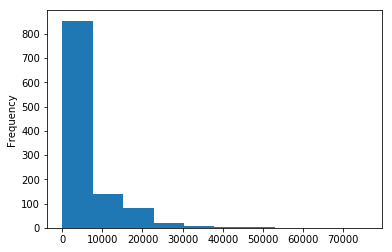

In [15]:
# Fill missing values- CompetitionDistance
print(store_info.CompetitionDistance.describe())
store_info.CompetitionDistance.plot.hist();

The distribution of CompetitionDistance is extreme positive skew and above we can see that the mean is much bigger than median. So I think fill missing valu with median is better than mean cause mean was dragged by outliters.

In [16]:
store_info.CompetitionDistance.fillna(store_info.CompetitionDistance.median(),inplace=True)
store_info.CompetitionDistance.isnull().any()

False

In [17]:
def create_dummy(datasets, columns):
    new_dataset=[]
    for n in range(len(datasets)):
        data= datasets[n]
        for name in columns:
            if data[name].isnull().any()== False:
                temp= pd.get_dummies(data= data[name], prefix= name, dummy_na= False, drop_first= True)
                data= pd.merge(data, temp, left_index=True, right_index=True)
                data= data.drop(name, axis= 1)
            else:
                temp= pd.get_dummies(data= data[name], prefix= name, dummy_na= False, drop_first= False)
                data= pd.merge(data, temp, left_index=True, right_index=True)
                data= data.drop(name, axis= 1)                
        new_dataset.append(data)
    return new_dataset


In [18]:
temp= create_dummy([training,testing],['StateHoliday'])
training= temp[0]
testing= temp[1]
store_info= create_dummy([store_info],['StoreType','Assortment','PromoInterval','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'])[0]

## To keep number of features equal

In [21]:
testing['StateHoliday_b']=0
testing['StateHoliday_c']=0

## Import weather information

In [22]:
berlin= pd.read_csv('./weather/berlin.csv')
bremen= pd.read_csv('./weather/bremen.csv')
dusseldorf= pd.read_csv('./weather/dusseldorf.csv')
erfurt= pd.read_csv('./weather/erfurt.csv')
frankfurt= pd.read_csv('./weather/frankfurt.csv')
hamburg= pd.read_csv('./weather/hamburg.csv')
munich= pd.read_csv('./weather/munich.csv')
stuttgart= pd.read_csv('./weather/stuttgart.csv')

In [23]:
berlin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 24 columns):
Unnamed: 0                    990 non-null int64
Date                          990 non-null object
Max_TemperatureC              990 non-null int64
Mean_TemperatureC             990 non-null int64
Min_TemperatureC              990 non-null int64
Dew_PointC                    990 non-null int64
MeanDew_PointC                990 non-null int64
Min_DewpointC                 990 non-null int64
Max_Humidity                  990 non-null int64
Mean_Humidity                 990 non-null int64
Min_Humidity                  990 non-null int64
Max_Sea_Level_PressurehPa     990 non-null int64
Mean_Sea_Level_PressurehPa    990 non-null int64
Min_Sea_Level_PressurehPa     990 non-null int64
Max_VisibilityKm              977 non-null float64
Mean_VisibilityKm             977 non-null float64
Min_VisibilitykM              977 non-null float64
Max_Wind_SpeedKm_h            990 non-null int64
Mean_W

In [24]:
bremen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 25 columns):
Unnamed: 0                    990 non-null int64
Date                          990 non-null object
Max_TemperatureC              990 non-null int64
Mean_TemperatureC             990 non-null int64
Min_TemperatureC              990 non-null int64
Dew_PointC                    990 non-null int64
MeanDew_PointC                990 non-null int64
Min_DewpointC                 990 non-null int64
Max_Humidity                  990 non-null int64
Mean_Humidity                 990 non-null int64
Min_Humidity                  990 non-null int64
Max_Sea_Level_PressurehPa     990 non-null int64
Mean_Sea_Level_PressurehPa    990 non-null int64
Min_Sea_Level_PressurehPa     990 non-null int64
Max_VisibilityKm              985 non-null float64
Mean_VisibilityKm             985 non-null float64
Min_VisibilitykM              985 non-null float64
Max_Wind_SpeedKm_h            990 non-null int64
Mean_W

In [25]:
dusseldorf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 24 columns):
Unnamed: 0                    990 non-null int64
Date                          990 non-null object
Max_TemperatureC              990 non-null int64
Mean_TemperatureC             990 non-null int64
Min_TemperatureC              990 non-null int64
Dew_PointC                    990 non-null int64
MeanDew_PointC                990 non-null int64
Min_DewpointC                 990 non-null int64
Max_Humidity                  990 non-null int64
Mean_Humidity                 990 non-null int64
Min_Humidity                  990 non-null int64
Max_Sea_Level_PressurehPa     990 non-null int64
Mean_Sea_Level_PressurehPa    990 non-null int64
Min_Sea_Level_PressurehPa     990 non-null int64
Max_VisibilityKm              982 non-null float64
Mean_VisibilityKm             982 non-null float64
Min_VisibilitykM              982 non-null float64
Max_Wind_SpeedKm_h            990 non-null int64
Mean_W

In [26]:
erfurt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 25 columns):
Unnamed: 0                    990 non-null int64
Date                          990 non-null object
Max_TemperatureC              990 non-null int64
Mean_TemperatureC             990 non-null int64
Min_TemperatureC              990 non-null int64
Dew_PointC                    990 non-null int64
MeanDew_PointC                990 non-null int64
Min_DewpointC                 990 non-null int64
Max_Humidity                  990 non-null int64
Mean_Humidity                 990 non-null int64
Min_Humidity                  990 non-null int64
Max_Sea_Level_PressurehPa     990 non-null int64
Mean_Sea_Level_PressurehPa    990 non-null int64
Min_Sea_Level_PressurehPa     990 non-null int64
Max_VisibilityKm              958 non-null float64
Mean_VisibilityKm             958 non-null float64
Min_VisibilitykM              958 non-null float64
Max_Wind_SpeedKm_h            990 non-null int64
Mean_W

In [27]:
frankfurt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 25 columns):
Unnamed: 0                    990 non-null int64
Date                          990 non-null object
Max_TemperatureC              990 non-null int64
Mean_TemperatureC             990 non-null int64
Min_TemperatureC              990 non-null int64
Dew_PointC                    990 non-null int64
MeanDew_PointC                990 non-null int64
Min_DewpointC                 990 non-null int64
Max_Humidity                  990 non-null int64
Mean_Humidity                 990 non-null int64
Min_Humidity                  990 non-null int64
Max_Sea_Level_PressurehPa     990 non-null int64
Mean_Sea_Level_PressurehPa    990 non-null int64
Min_Sea_Level_PressurehPa     990 non-null int64
Max_VisibilityKm              961 non-null float64
Mean_VisibilityKm             961 non-null float64
Min_VisibilitykM              961 non-null float64
Max_Wind_SpeedKm_h            990 non-null int64
Mean_W

In [28]:
hamburg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 25 columns):
Unnamed: 0                    990 non-null int64
Date                          990 non-null object
Max_TemperatureC              990 non-null int64
Mean_TemperatureC             990 non-null int64
Min_TemperatureC              990 non-null int64
Dew_PointC                    990 non-null int64
MeanDew_PointC                990 non-null int64
Min_DewpointC                 990 non-null int64
Max_Humidity                  990 non-null int64
Mean_Humidity                 990 non-null int64
Min_Humidity                  990 non-null int64
Max_Sea_Level_PressurehPa     990 non-null int64
Mean_Sea_Level_PressurehPa    990 non-null int64
Min_Sea_Level_PressurehPa     990 non-null int64
Max_VisibilityKm              936 non-null float64
Mean_VisibilityKm             936 non-null float64
Min_VisibilitykM              936 non-null float64
Max_Wind_SpeedKm_h            990 non-null int64
Mean_W

In [29]:
munich.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 25 columns):
Unnamed: 0                    987 non-null int64
Date                          987 non-null object
Max_TemperatureC              987 non-null int64
Mean_TemperatureC             987 non-null int64
Min_TemperatureC              987 non-null int64
Dew_PointC                    987 non-null int64
MeanDew_PointC                987 non-null int64
Min_DewpointC                 987 non-null int64
Max_Humidity                  987 non-null int64
Mean_Humidity                 987 non-null int64
Min_Humidity                  987 non-null int64
Max_Sea_Level_PressurehPa     987 non-null int64
Mean_Sea_Level_PressurehPa    987 non-null int64
Min_Sea_Level_PressurehPa     987 non-null int64
Max_VisibilityKm              933 non-null float64
Mean_VisibilityKm             933 non-null float64
Min_VisibilitykM              933 non-null float64
Max_Wind_SpeedKm_h            987 non-null int64
Mean_W

In [30]:
stuttgart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 25 columns):
Unnamed: 0                    990 non-null int64
Date                          990 non-null object
Max_TemperatureC              990 non-null int64
Mean_TemperatureC             990 non-null int64
Min_TemperatureC              990 non-null int64
Dew_PointC                    990 non-null int64
MeanDew_PointC                990 non-null int64
Min_DewpointC                 990 non-null int64
Max_Humidity                  990 non-null int64
Mean_Humidity                 990 non-null int64
Min_Humidity                  990 non-null int64
Max_Sea_Level_PressurehPa     990 non-null int64
Mean_Sea_Level_PressurehPa    990 non-null int64
Min_Sea_Level_PressurehPa     990 non-null int64
Max_VisibilityKm              952 non-null float64
Mean_VisibilityKm             952 non-null float64
Min_VisibilitykM              952 non-null float64
Max_Wind_SpeedKm_h            990 non-null int64
Mean_W

In [31]:
city_weather= [berlin, bremen, dusseldorf, erfurt, frankfurt, hamburg, munich, stuttgart]
city_name= ['_Berlin', '_Bremen', '_Dusseldorf', '_Erfurt', '_Frankfurt', '_Hamburg', '_Munich', '_Stuttgart']

# Drop max and min columns, only remain mean
for i in range(len(city_weather)):
    city_weather[i].drop(['Unnamed: 0','Max_TemperatureC','Min_TemperatureC','Min_DewpointC','Dew_PointC','Max_Humidity','Min_Humidity','Max_Sea_Level_PressurehPa','Min_Sea_Level_PressurehPa','Max_VisibilityKm','Min_VisibilitykM','Max_Wind_SpeedKm_h','Max_Gust_SpeedKm_h'],axis=1,inplace= True)
    if (i != 0) and (i != 2):
        city_weather[i].drop('Station',axis= 1, inplace= True)

# Merge them together
weather_all = berlin.copy()
for i in range(0,(len(city_weather)-1)):
    weather_all= weather_all.merge(city_weather[i+1],on='Date',suffixes=(city_name[i],city_name[i+1]))

In [32]:
# fillna with value mean of each not-object column
for i in range(len(weather_all.columns)):
    column_name= weather_all.columns[i]
    type_= weather_all.dtypes[i]
    if (type_== int) or (type_== float):
        weather_all[column_name]= weather_all[column_name].fillna(int(np.mean(weather_all[column_name])))

In [33]:
weather_all.info() # Double check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 986
Data columns (total 81 columns):
Date                                     987 non-null object
Mean_TemperatureC_Berlin                 987 non-null int64
MeanDew_PointC_Berlin                    987 non-null int64
Mean_Humidity_Berlin                     987 non-null int64
Mean_Sea_Level_PressurehPa_Berlin        987 non-null int64
Mean_VisibilityKm_Berlin                 987 non-null float64
Mean_Wind_SpeedKm_h_Berlin               987 non-null int64
Precipitationmm_Berlin                   987 non-null float64
CloudCover_Berlin                        987 non-null float64
Events_Berlin                            766 non-null object
WindDirDegrees_Berlin                    987 non-null int64
Mean_TemperatureC_Bremen                 987 non-null int64
MeanDew_PointC_Bremen                    987 non-null int64
Mean_Humidity_Bremen                     987 non-null int64
Mean_Sea_Level_PressurehPa_Bremen        987 no

In [34]:
def create_dummy_weather(datasets, columns):
    new_dataset=[]
    for n in range(len(datasets)):
        data= datasets[n]
        for name in columns:
            if data[name].isnull().any()== False:
                continue
            else:
                temp= pd.get_dummies(data= data[name], prefix= name, dummy_na= False, drop_first= False)
                data= pd.merge(data, temp, left_index=True, right_index=True)
                data= data.drop(name, axis= 1)                
        new_dataset.append(data)
    return new_dataset

In [35]:
# Merge weather to training set and testing set
weather_all= create_dummy_weather([weather_all],list(weather_all.columns))[0]

## Add summer holiday information

In [36]:
# Create a Summer holiday feature with default value 0(NOt in holiday)
# region name  Baden_Wuerttemberg, Bavaria, Berlin, Brandenburg, Bremen,Hamburg,Hesse,Lower Saxony,Mecklenburg Western Pomerania,Northrhine-Westphalia,Rhineland Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig Holstein,Thuringia
region= ['Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hesse', 'Lower Saxony', 'Mecklenburg Western Pomerania','Northrhine-Westphalia','Rhineland Palatinate','Saarland','Saxony','Saxony-Anhalt','Schleswig Holstein','Thuringia']
for i in region:
    training[i]=0
    testing[i]=0

In [37]:
region_dict = {}
years= {2013:0,
2014:0,
2015:0}
for i in region:
    region_dict[i]= years

# 'Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen', 
#'Hamburg', 'Hesse', 'Lower Saxony', 'Mecklenburg Western Pomerania','Northrhine-Westphalia',
#'Rhineland Palatinate','Saarland','Saxony','Saxony-Anhalt','Schleswig Holstein','Thuringia'
for i in range(len(region)):
    current_region= region[i]
    if i ==0:
        years[2013]= [dt.datetime.strptime('2013-07-25' ,'%Y-%m-%d'),dt.datetime.strptime('2013-09-07' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-31' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-13' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-30' ,'%Y-%m-%d'),dt.datetime.strptime('2015-09-12' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==1:
        years[2013]= [dt.datetime.strptime('2013-07-31' ,'%Y-%m-%d'),dt.datetime.strptime('2013-09-12' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-30' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-15' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-08-01' ,'%Y-%m-%d'),dt.datetime.strptime('2015-09-14' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==2:
        years[2013]= [dt.datetime.strptime('2013-06-20' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-02' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-10' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-22' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-16' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-28' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==3:
        years[2013]= [dt.datetime.strptime('2013-06-20' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-02' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-10' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-22' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-16' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-28' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==4:
        years[2013]= [dt.datetime.strptime('2013-06-27' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-07' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-31' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-10' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-23' ,'%Y-%m-%d'),dt.datetime.strptime('2015-09-02' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==5:
        years[2013]= [dt.datetime.strptime('2013-06-20' ,'%Y-%m-%d'),dt.datetime.strptime('2013-07-31' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-10' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-20' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-16' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-26' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==6:
        years[2013]= [dt.datetime.strptime('2013-07-08' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-16' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-28' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-05' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-27' ,'%Y-%m-%d'),dt.datetime.strptime('2015-09-05' ,'%Y-%m-%d')]
        region_dict[current_region]= years 
    if i ==7:
        years[2013]= [dt.datetime.strptime('2013-06-27' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-07' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-31' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-10' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-23' ,'%Y-%m-%d'),dt.datetime.strptime('2015-09-02' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==8:
        years[2013]= [dt.datetime.strptime('2013-06-22' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-03' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-14' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-23' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-20' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-29' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==9:
        years[2013]= [dt.datetime.strptime('2013-07-22' ,'%Y-%m-%d'),dt.datetime.strptime('2013-09-03' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-07' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-19' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-06-29' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-11' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==10:
        years[2013]= [dt.datetime.strptime('2013-07-08' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-16' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-28' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-05' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-27' ,'%Y-%m-%d'),dt.datetime.strptime('2015-09-04' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==11:
        years[2013]= [dt.datetime.strptime('2013-07-08' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-17' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-28' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-06' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-27' ,'%Y-%m-%d'),dt.datetime.strptime('2015-09-05' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==12:
        years[2013]= [dt.datetime.strptime('2013-07-15' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-23' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-21' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-29' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-13' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-21' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==13:
        years[2013]= [dt.datetime.strptime('2013-07-15' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-28' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-21' ,'%Y-%m-%d'),dt.datetime.strptime('2014-09-03' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-13' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-26' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==14:
        years[2013]= [dt.datetime.strptime('2013-06-24' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-03' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-14' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-23' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-20' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-29' ,'%Y-%m-%d')]
        region_dict[current_region]= years
    if i ==15:
        years[2013]= [dt.datetime.strptime('2013-07-15' ,'%Y-%m-%d'),dt.datetime.strptime('2013-08-23' ,'%Y-%m-%d')]
        years[2014]= [dt.datetime.strptime('2014-07-21' ,'%Y-%m-%d'),dt.datetime.strptime('2014-08-29' ,'%Y-%m-%d')]
        years[2015]= [dt.datetime.strptime('2015-07-13' ,'%Y-%m-%d'),dt.datetime.strptime('2015-08-21' ,'%Y-%m-%d')]
        region_dict[current_region]= years

In [38]:
for place, years in region_dict.items():
    for year, duration in years.items():
         for current in training[(training.Month>5)&(training.Month<10)].Date.unique().tolist():
                date_curr = dt.datetime.strptime(current,'%Y-%m-%d')
                if (date_curr >= duration[0]) and (date_curr <= duration[1]):
                    training.loc[training.Date== current,place]= 1

In [39]:
# for place, years in region_dict.items():
#     for year, duration in years.items():
#          for current in testing[(testing.Month>5)&(testing.Month<10)].Date.unique().tolist():
#                 date_curr = dt.datetime.strptime(current,'%Y-%m-%d')
#                 if (date_curr >= duration[0]) and (date_curr <= duration[1]):
#                     testing.loc[testing.Date== current,place]= 1

# Save files

In [40]:
training.to_csv('training_1.csv',index=False)
testing.to_csv('testing_1.csv',index=False)
store_info.to_csv('store_info_1.csv',index=False)
weather_all.to_csv('weather_all_1.csv',index=False)